In [1]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# loading the xtc and gro file into mdtraj
traj = md.load('../../../xtc_files/50000eql2.xtc', top='../../../xtc_files/conf.gro')

In [3]:
# converting traj as traj with only 5000 frames
traj=traj[::3]

In [4]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in tqdm(range(nframes)):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

100%|██████████| 16667/16667 [01:18<00:00, 211.37it/s]


(16667, 592, 3)


In [5]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in tqdm(range(nframes)):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

100%|██████████| 16667/16667 [2:22:58<00:00,  1.94it/s]  

16667


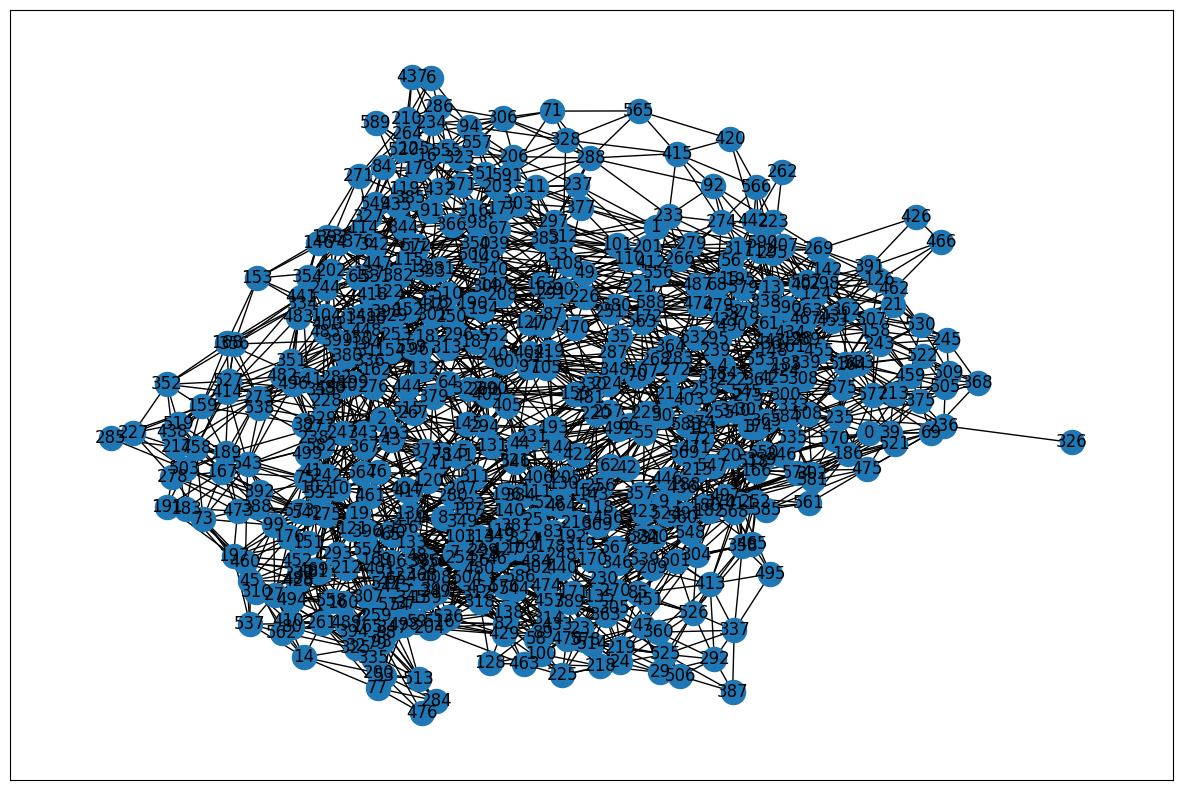

In [6]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [7]:
graphs = []
for frame in tqdm(range(nframes)):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

100%|██████████| 16667/16667 [00:01<00:00, 16351.42it/s]

Data(x=[592, 3], edge_index=[2, 8126], y=[1])


In [8]:
# import model.
from model import *

In [9]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
from pytorch3d.loss import chamfer_distance

In [11]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [12]:
#for data in train_loader_set:
#    z,encoded_edgeindex=model.encode(data.x,data.edge_index)
#    decodedx,decoded_edgeindex=model.decode(z,encoded_edgeindex)
#    # print(data)
#    print(decodedx)
#    print("data.x")
#    print(data.x)
#    print("sizes")
#    print(decodedx.size())
#    print(data.x.size())

In [13]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [14]:
# writing a vakidation function
def validate():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in validation_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

    return loss_all / len(validation_loader_set.dataset),closs_all/len(validation_loader_set.dataset), feature_loss_all / len(validation_loader_set.dataset), edge_loss_all / len(validation_loader_set.dataset), kl_loss_all / len(validation_loader_set.dataset)

In [15]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    type_loss_all = 0
    closs_all=0
    for data in test_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index= model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss+closs 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        

    return loss_all / len(test_loader_set.dataset), closs_all/len(test_loader_set.dataset),feature_loss_all / len(test_loader_set.dataset), edge_loss_all / len(test_loader_set.dataset), kl_loss_all / len(test_loader_set.dataset)

In [16]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []
val_total_losses = []
val_feature_losses = []
val_edge_losses = []
val_kl_losses = []
test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []
cd_losses=[]
val_cd_losses=[]
test_cd_losses=[]
for epoch in tqdm(range(1, epochs+ 1)):
    total_loss, cd_loss,feature_loss, edge_loss, kl_loss = train()
    val_total_loss, val_cd_loss,val_feature_loss, val_edge_loss, val_kl_loss = validate()
    test_total_loss, test_cd_loss,test_feature_loss, test_edge_loss, test_kl_loss = test()
    print(f'Epoch: {epoch:03d}')
    print(f'TRAIN : Total Loss: {total_loss:.4f}, CD Loss : {cd_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}')
    print(f'VALIDATE : Total Loss: {val_total_loss:.4f}, CD Loss : {val_cd_loss:.4f},Feature Loss: {val_feature_loss:.4f}, Edge Loss: {val_edge_loss:.4f}')
    print(f'TEST : Total Loss: {test_total_loss:.4f},CD Loss : {test_cd_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Edge Loss: {test_edge_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)
    val_total_losses.append(val_total_loss)
    val_feature_losses.append(val_feature_loss)
    val_edge_losses.append(val_edge_loss)
    val_kl_losses.append(val_kl_loss)
    test_total_losses.append(test_total_loss)
    test_feature_losses.append(test_feature_loss)
    test_edge_losses.append(test_edge_loss)
    test_kl_losses.append(test_kl_loss)
    cd_losses.append(cd_loss)
    val_cd_losses.append(val_cd_loss)   
    test_cd_losses.append(test_cd_loss) 
    

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3904/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_3904/368484634.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_3904/3817500453.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
  1%|          | 1/100 [02:01<3:21:02, 121.84s/it]

Epoch: 001
TRAIN : Total Loss: 2.4660, CD Loss : 1.7158, Feature Loss: 0.7502, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.4549, CD Loss : 1.0508,Feature Loss: 0.4041, Edge Loss: 0.0000
TEST : Total Loss: 1.4562,CD Loss : 1.0519, Feature Loss: 0.4043, Edge Loss: 0.0000


  2%|▏         | 2/100 [04:17<3:32:13, 129.93s/it]

Epoch: 002
TRAIN : Total Loss: 1.0429, CD Loss : 0.7341, Feature Loss: 0.3088, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.8257, CD Loss : 0.6036,Feature Loss: 0.2221, Edge Loss: 0.0000
TEST : Total Loss: 0.8258,CD Loss : 0.6037, Feature Loss: 0.2220, Edge Loss: 0.0000


  3%|▎         | 3/100 [06:42<3:41:29, 137.01s/it]

Epoch: 003
TRAIN : Total Loss: 0.8087, CD Loss : 0.5889, Feature Loss: 0.2198, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.7613, CD Loss : 0.5526,Feature Loss: 0.2087, Edge Loss: 0.0000
TEST : Total Loss: 0.7616,CD Loss : 0.5530, Feature Loss: 0.2086, Edge Loss: 0.0000


  4%|▍         | 4/100 [09:02<3:41:00, 138.13s/it]

Epoch: 004
TRAIN : Total Loss: 0.5586, CD Loss : 0.3853, Feature Loss: 0.1732, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4361, CD Loss : 0.2895,Feature Loss: 0.1466, Edge Loss: 0.0000
TEST : Total Loss: 0.4369,CD Loss : 0.2902, Feature Loss: 0.1468, Edge Loss: 0.0000


  5%|▌         | 5/100 [11:09<3:32:10, 134.01s/it]

Epoch: 005
TRAIN : Total Loss: 0.4262, CD Loss : 0.2845, Feature Loss: 0.1417, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4217, CD Loss : 0.2830,Feature Loss: 0.1387, Edge Loss: 0.0000
TEST : Total Loss: 0.4224,CD Loss : 0.2836, Feature Loss: 0.1388, Edge Loss: 0.0000


  6%|▌         | 6/100 [13:28<3:32:54, 135.90s/it]

Epoch: 006
TRAIN : Total Loss: 0.4173, CD Loss : 0.2807, Feature Loss: 0.1366, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4124, CD Loss : 0.2777,Feature Loss: 0.1348, Edge Loss: 0.0000
TEST : Total Loss: 0.4130,CD Loss : 0.2782, Feature Loss: 0.1348, Edge Loss: 0.0000


  7%|▋         | 7/100 [15:44<3:30:17, 135.68s/it]

Epoch: 007
TRAIN : Total Loss: 0.4028, CD Loss : 0.2705, Feature Loss: 0.1323, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3902, CD Loss : 0.2603,Feature Loss: 0.1298, Edge Loss: 0.0000
TEST : Total Loss: 0.3907,CD Loss : 0.2608, Feature Loss: 0.1299, Edge Loss: 0.0000


  8%|▊         | 8/100 [18:07<3:31:51, 138.16s/it]

Epoch: 008
TRAIN : Total Loss: 0.3680, CD Loss : 0.2424, Feature Loss: 0.1256, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3453, CD Loss : 0.2239,Feature Loss: 0.1215, Edge Loss: 0.0000
TEST : Total Loss: 0.3458,CD Loss : 0.2243, Feature Loss: 0.1215, Edge Loss: 0.0000


  9%|▉         | 9/100 [20:32<3:32:47, 140.31s/it]

Epoch: 009
TRAIN : Total Loss: 0.3241, CD Loss : 0.2078, Feature Loss: 0.1163, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3034, CD Loss : 0.1924,Feature Loss: 0.1110, Edge Loss: 0.0000
TEST : Total Loss: 0.3039,CD Loss : 0.1928, Feature Loss: 0.1111, Edge Loss: 0.0000


 10%|█         | 10/100 [22:50<3:29:19, 139.55s/it]

Epoch: 010
TRAIN : Total Loss: 0.2839, CD Loss : 0.1791, Feature Loss: 0.1048, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2649, CD Loss : 0.1658,Feature Loss: 0.0992, Edge Loss: 0.0000
TEST : Total Loss: 0.2653,CD Loss : 0.1662, Feature Loss: 0.0991, Edge Loss: 0.0000


 11%|█         | 11/100 [25:03<3:23:53, 137.46s/it]

Epoch: 011
TRAIN : Total Loss: 0.2516, CD Loss : 0.1571, Feature Loss: 0.0945, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2410, CD Loss : 0.1498,Feature Loss: 0.0911, Edge Loss: 0.0000
TEST : Total Loss: 0.2412,CD Loss : 0.1502, Feature Loss: 0.0911, Edge Loss: 0.0000


 12%|█▏        | 12/100 [27:32<3:26:58, 141.12s/it]

Epoch: 012
TRAIN : Total Loss: 0.2319, CD Loss : 0.1436, Feature Loss: 0.0882, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2244, CD Loss : 0.1382,Feature Loss: 0.0862, Edge Loss: 0.0000
TEST : Total Loss: 0.2244,CD Loss : 0.1384, Feature Loss: 0.0861, Edge Loss: 0.0000


 13%|█▎        | 13/100 [29:48<3:22:19, 139.53s/it]

Epoch: 013
TRAIN : Total Loss: 0.2183, CD Loss : 0.1342, Feature Loss: 0.0842, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2129, CD Loss : 0.1298,Feature Loss: 0.0832, Edge Loss: 0.0000
TEST : Total Loss: 0.2128,CD Loss : 0.1298, Feature Loss: 0.0830, Edge Loss: 0.0000


 14%|█▍        | 14/100 [32:12<3:21:59, 140.92s/it]

Epoch: 014
TRAIN : Total Loss: 0.2096, CD Loss : 0.1277, Feature Loss: 0.0820, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2081, CD Loss : 0.1264,Feature Loss: 0.0817, Edge Loss: 0.0000
TEST : Total Loss: 0.2078,CD Loss : 0.1264, Feature Loss: 0.0814, Edge Loss: 0.0000


 15%|█▌        | 15/100 [34:23<3:15:21, 137.90s/it]

Epoch: 015
TRAIN : Total Loss: 0.2049, CD Loss : 0.1240, Feature Loss: 0.0808, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2038, CD Loss : 0.1230,Feature Loss: 0.0809, Edge Loss: 0.0000
TEST : Total Loss: 0.2035,CD Loss : 0.1229, Feature Loss: 0.0806, Edge Loss: 0.0000


 16%|█▌        | 16/100 [36:38<3:11:42, 136.93s/it]

Epoch: 016
TRAIN : Total Loss: 0.2022, CD Loss : 0.1220, Feature Loss: 0.0802, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2026, CD Loss : 0.1221,Feature Loss: 0.0804, Edge Loss: 0.0000
TEST : Total Loss: 0.2023,CD Loss : 0.1221, Feature Loss: 0.0802, Edge Loss: 0.0000


 17%|█▋        | 17/100 [38:45<3:05:28, 134.08s/it]

Epoch: 017
TRAIN : Total Loss: 0.2004, CD Loss : 0.1207, Feature Loss: 0.0796, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2003, CD Loss : 0.1205,Feature Loss: 0.0798, Edge Loss: 0.0000
TEST : Total Loss: 0.2000,CD Loss : 0.1204, Feature Loss: 0.0796, Edge Loss: 0.0000


 18%|█▊        | 18/100 [40:50<2:59:26, 131.30s/it]

Epoch: 018
TRAIN : Total Loss: 0.1991, CD Loss : 0.1199, Feature Loss: 0.0792, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1992, CD Loss : 0.1199,Feature Loss: 0.0793, Edge Loss: 0.0000
TEST : Total Loss: 0.1989,CD Loss : 0.1198, Feature Loss: 0.0791, Edge Loss: 0.0000


 19%|█▉        | 19/100 [43:18<3:03:57, 136.27s/it]

Epoch: 019
TRAIN : Total Loss: 0.1980, CD Loss : 0.1193, Feature Loss: 0.0787, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1985, CD Loss : 0.1195,Feature Loss: 0.0789, Edge Loss: 0.0000
TEST : Total Loss: 0.1981,CD Loss : 0.1195, Feature Loss: 0.0787, Edge Loss: 0.0000


 20%|██        | 20/100 [45:34<3:01:27, 136.09s/it]

Epoch: 020
TRAIN : Total Loss: 0.1971, CD Loss : 0.1188, Feature Loss: 0.0783, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1970, CD Loss : 0.1185,Feature Loss: 0.0785, Edge Loss: 0.0000
TEST : Total Loss: 0.1967,CD Loss : 0.1185, Feature Loss: 0.0783, Edge Loss: 0.0000


 21%|██        | 21/100 [47:50<2:59:21, 136.22s/it]

Epoch: 021
TRAIN : Total Loss: 0.1962, CD Loss : 0.1183, Feature Loss: 0.0779, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1963, CD Loss : 0.1181,Feature Loss: 0.0782, Edge Loss: 0.0000
TEST : Total Loss: 0.1959,CD Loss : 0.1180, Feature Loss: 0.0779, Edge Loss: 0.0000


 22%|██▏       | 22/100 [50:11<2:58:47, 137.53s/it]

Epoch: 022
TRAIN : Total Loss: 0.1954, CD Loss : 0.1179, Feature Loss: 0.0775, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1958, CD Loss : 0.1181,Feature Loss: 0.0778, Edge Loss: 0.0000
TEST : Total Loss: 0.1955,CD Loss : 0.1180, Feature Loss: 0.0775, Edge Loss: 0.0000


 23%|██▎       | 23/100 [52:28<2:56:13, 137.31s/it]

Epoch: 023
TRAIN : Total Loss: 0.1947, CD Loss : 0.1175, Feature Loss: 0.0772, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1949, CD Loss : 0.1175,Feature Loss: 0.0774, Edge Loss: 0.0000
TEST : Total Loss: 0.1946,CD Loss : 0.1174, Feature Loss: 0.0772, Edge Loss: 0.0000


 24%|██▍       | 24/100 [54:30<2:48:16, 132.85s/it]

Epoch: 024
TRAIN : Total Loss: 0.1940, CD Loss : 0.1171, Feature Loss: 0.0769, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1949, CD Loss : 0.1178,Feature Loss: 0.0772, Edge Loss: 0.0000
TEST : Total Loss: 0.1946,CD Loss : 0.1177, Feature Loss: 0.0769, Edge Loss: 0.0000


 25%|██▌       | 25/100 [56:49<2:48:20, 134.67s/it]

Epoch: 025
TRAIN : Total Loss: 0.1933, CD Loss : 0.1167, Feature Loss: 0.0766, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1938, CD Loss : 0.1169,Feature Loss: 0.0768, Edge Loss: 0.0000
TEST : Total Loss: 0.1934,CD Loss : 0.1168, Feature Loss: 0.0766, Edge Loss: 0.0000


 26%|██▌       | 26/100 [58:53<2:42:19, 131.61s/it]

Epoch: 026
TRAIN : Total Loss: 0.1927, CD Loss : 0.1164, Feature Loss: 0.0763, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1932, CD Loss : 0.1166,Feature Loss: 0.0766, Edge Loss: 0.0000
TEST : Total Loss: 0.1929,CD Loss : 0.1165, Feature Loss: 0.0763, Edge Loss: 0.0000


 27%|██▋       | 27/100 [1:01:11<2:42:18, 133.40s/it]

Epoch: 027
TRAIN : Total Loss: 0.1922, CD Loss : 0.1161, Feature Loss: 0.0761, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1926, CD Loss : 0.1162,Feature Loss: 0.0764, Edge Loss: 0.0000
TEST : Total Loss: 0.1923,CD Loss : 0.1161, Feature Loss: 0.0762, Edge Loss: 0.0000


 28%|██▊       | 28/100 [1:03:38<2:45:06, 137.58s/it]

Epoch: 028
TRAIN : Total Loss: 0.1916, CD Loss : 0.1158, Feature Loss: 0.0758, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1924, CD Loss : 0.1162,Feature Loss: 0.0761, Edge Loss: 0.0000
TEST : Total Loss: 0.1920,CD Loss : 0.1162, Feature Loss: 0.0759, Edge Loss: 0.0000


 29%|██▉       | 29/100 [1:06:04<2:45:49, 140.14s/it]

Epoch: 029
TRAIN : Total Loss: 0.1912, CD Loss : 0.1156, Feature Loss: 0.0756, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1916, CD Loss : 0.1157,Feature Loss: 0.0759, Edge Loss: 0.0000
TEST : Total Loss: 0.1913,CD Loss : 0.1156, Feature Loss: 0.0757, Edge Loss: 0.0000


 30%|███       | 30/100 [1:08:18<2:41:02, 138.03s/it]

Epoch: 030
TRAIN : Total Loss: 0.1907, CD Loss : 0.1153, Feature Loss: 0.0754, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1913, CD Loss : 0.1156,Feature Loss: 0.0757, Edge Loss: 0.0000
TEST : Total Loss: 0.1910,CD Loss : 0.1155, Feature Loss: 0.0755, Edge Loss: 0.0000


 31%|███       | 31/100 [1:10:36<2:38:54, 138.19s/it]

Epoch: 031
TRAIN : Total Loss: 0.1903, CD Loss : 0.1151, Feature Loss: 0.0752, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1913, CD Loss : 0.1157,Feature Loss: 0.0756, Edge Loss: 0.0000
TEST : Total Loss: 0.1910,CD Loss : 0.1156, Feature Loss: 0.0753, Edge Loss: 0.0000


 32%|███▏      | 32/100 [1:12:48<2:34:24, 136.24s/it]

Epoch: 032
TRAIN : Total Loss: 0.1899, CD Loss : 0.1148, Feature Loss: 0.0751, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1908, CD Loss : 0.1154,Feature Loss: 0.0754, Edge Loss: 0.0000
TEST : Total Loss: 0.1905,CD Loss : 0.1153, Feature Loss: 0.0752, Edge Loss: 0.0000


 33%|███▎      | 33/100 [1:15:00<2:30:46, 135.03s/it]

Epoch: 033
TRAIN : Total Loss: 0.1895, CD Loss : 0.1146, Feature Loss: 0.0749, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1897, CD Loss : 0.1144,Feature Loss: 0.0752, Edge Loss: 0.0000
TEST : Total Loss: 0.1893,CD Loss : 0.1144, Feature Loss: 0.0750, Edge Loss: 0.0000


 34%|███▍      | 34/100 [1:17:29<2:33:14, 139.32s/it]

Epoch: 034
TRAIN : Total Loss: 0.1892, CD Loss : 0.1144, Feature Loss: 0.0747, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1895, CD Loss : 0.1144,Feature Loss: 0.0751, Edge Loss: 0.0000
TEST : Total Loss: 0.1892,CD Loss : 0.1144, Feature Loss: 0.0748, Edge Loss: 0.0000


 35%|███▌      | 35/100 [1:19:54<2:32:41, 140.94s/it]

Epoch: 035
TRAIN : Total Loss: 0.1888, CD Loss : 0.1142, Feature Loss: 0.0746, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1892, CD Loss : 0.1142,Feature Loss: 0.0750, Edge Loss: 0.0000
TEST : Total Loss: 0.1889,CD Loss : 0.1142, Feature Loss: 0.0748, Edge Loss: 0.0000


 36%|███▌      | 36/100 [1:22:11<2:29:03, 139.74s/it]

Epoch: 036
TRAIN : Total Loss: 0.1885, CD Loss : 0.1141, Feature Loss: 0.0745, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1892, CD Loss : 0.1144,Feature Loss: 0.0748, Edge Loss: 0.0000
TEST : Total Loss: 0.1889,CD Loss : 0.1143, Feature Loss: 0.0745, Edge Loss: 0.0000


 37%|███▋      | 37/100 [1:24:29<2:26:13, 139.26s/it]

Epoch: 037
TRAIN : Total Loss: 0.1882, CD Loss : 0.1139, Feature Loss: 0.0743, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1890, CD Loss : 0.1144,Feature Loss: 0.0747, Edge Loss: 0.0000
TEST : Total Loss: 0.1887,CD Loss : 0.1143, Feature Loss: 0.0744, Edge Loss: 0.0000


 38%|███▊      | 38/100 [1:26:54<2:25:41, 140.98s/it]

Epoch: 038
TRAIN : Total Loss: 0.1879, CD Loss : 0.1137, Feature Loss: 0.0742, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1882, CD Loss : 0.1136,Feature Loss: 0.0746, Edge Loss: 0.0000
TEST : Total Loss: 0.1879,CD Loss : 0.1135, Feature Loss: 0.0744, Edge Loss: 0.0000


 39%|███▉      | 39/100 [1:29:21<2:25:06, 142.73s/it]

Epoch: 039
TRAIN : Total Loss: 0.1877, CD Loss : 0.1136, Feature Loss: 0.0741, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1882, CD Loss : 0.1138,Feature Loss: 0.0744, Edge Loss: 0.0000
TEST : Total Loss: 0.1879,CD Loss : 0.1137, Feature Loss: 0.0742, Edge Loss: 0.0000


 40%|████      | 40/100 [1:31:46<2:23:22, 143.38s/it]

Epoch: 040
TRAIN : Total Loss: 0.1874, CD Loss : 0.1134, Feature Loss: 0.0740, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1886, CD Loss : 0.1142,Feature Loss: 0.0744, Edge Loss: 0.0000
TEST : Total Loss: 0.1883,CD Loss : 0.1142, Feature Loss: 0.0741, Edge Loss: 0.0000


 41%|████      | 41/100 [1:34:07<2:20:14, 142.61s/it]

Epoch: 041
TRAIN : Total Loss: 0.1872, CD Loss : 0.1133, Feature Loss: 0.0739, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1876, CD Loss : 0.1134,Feature Loss: 0.0742, Edge Loss: 0.0000
TEST : Total Loss: 0.1873,CD Loss : 0.1133, Feature Loss: 0.0740, Edge Loss: 0.0000


 42%|████▏     | 42/100 [1:36:20<2:15:13, 139.88s/it]

Epoch: 042
TRAIN : Total Loss: 0.1869, CD Loss : 0.1131, Feature Loss: 0.0738, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.1874, CD Loss : 0.1133,Feature Loss: 0.0741, Edge Loss: 0.0000
TEST : Total Loss: 0.1871,CD Loss : 0.1132, Feature Loss: 0.0739, Edge Loss: 0.0000


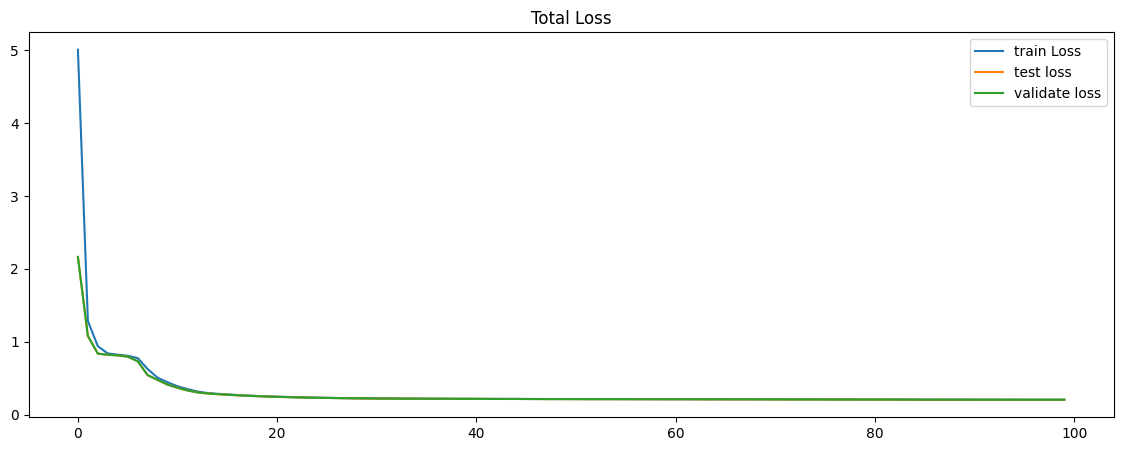

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='train Loss')
plt.plot(test_total_losses, label='test loss')
plt.plot(val_total_losses, label='validate loss')
plt.legend()
plt.title('Total Loss')
plt.show()

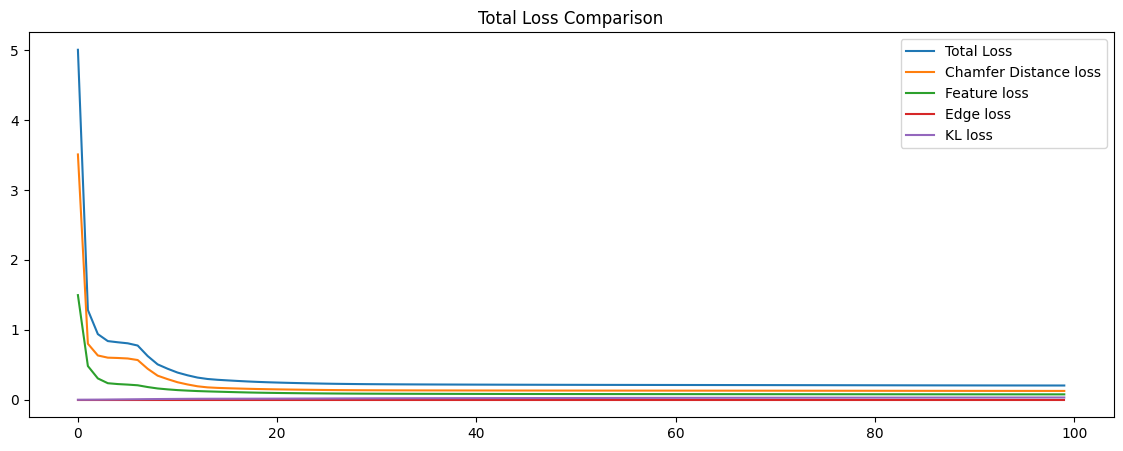

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='Total Loss')
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(feature_losses, label='Feature loss')
plt.plot(edge_losses, label='Edge loss')
plt.plot(kl_losses, label='KL loss')
plt.legend()
plt.title('Total Loss Comparison')
plt.show()

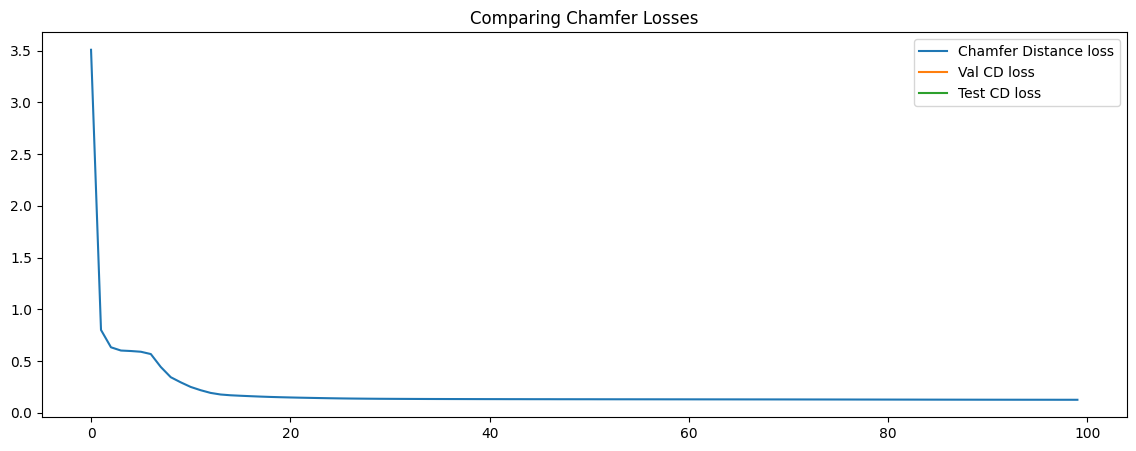

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(val_cd_loss, label='Val CD loss')
plt.plot(test_cd_loss, label='Test CD loss')
plt.legend()
plt.title('Comparing Chamfer Losses')
plt.show()

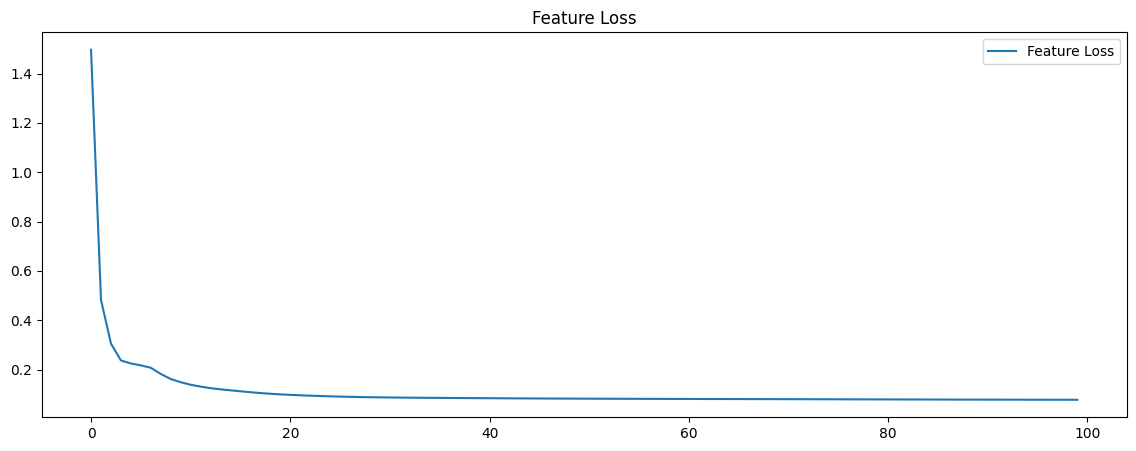

In [ ]:

plt.figure(figsize=(14, 5))
plt.plot(feature_losses, label='Feature Loss')
plt.legend()
plt.title('Feature Loss')
plt.show()